In [1]:
%pylab inline
import camels_library as cl
import readgadget
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
init_cond = '/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/ICs/ics'

header   = readgadget.header(init_cond)
BoxSize  = header.boxsize/1e3  #Mpc/h
Nall     = header.nall         #Total number of particles
Masses   = header.massarr*1e10 #Masses of the particles in Msun/h
Omega_m  = header.omega_m      #value of Omega_m
Omega_l  = header.omega_l      #value of Omega_l
h        = header.hubble       #value of h
redshift = header.redshift     #redshift of the snapshot
Hubble   = 100.0*np.sqrt(Omega_m*(1.0+redshift)**3+Omega_l)#Value of H(z) in km/s/(Mpc/h)

ptype = [1] #dark matter is particle type 1
ids_i = np.argsort(readgadget.read_block(init_cond, "ID  ", ptype)-1)  #IDs starting from 0
pos_i = readgadget.read_block(init_cond, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_i = readgadget.read_block(init_cond, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_i = pos_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_i = vel_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_i = (pos_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_i = (vel_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
a_i   = 1./(1+redshift)

In [3]:
scales = []
poss = []
vels = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot='/data/CAMELS/Sims/IllustrisTNG_DM/CV_0/snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    h        = header.hubble       #value of h
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3 #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]     #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    scales.append((1./(1+redshift)))
    poss.append(pos)
    vels.append(vel)

100%|██████████| 34/34 [01:54<00:00,  3.36s/it]


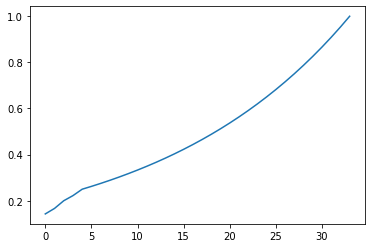

In [4]:
plot(scales)

In [5]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc
import haiku as hk

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read
from jaxpm.pm import linear_field, lpt, make_ode_fn, pm_forces
from jaxpm.kernels import fftk, gradient_kernel, laplace_kernel, longrange_kernel

In [6]:
mesh_shape= [64,64, 64]
box_size  = [25.,25.,25.]
cosmo = jc.Planck15(Omega_c= 0.3 - 0.049, Omega_b=0.049, n_s=0.9624, h=0.671 , sigma8=0.8)

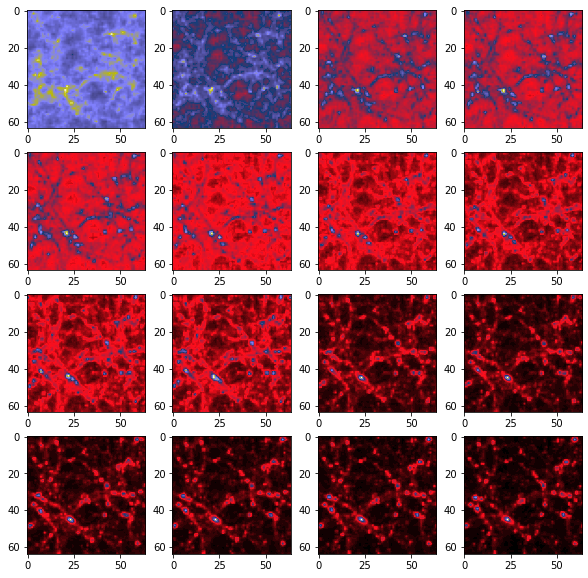

In [7]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern', vmin=0)

## Defining the force correction kernel

In [8]:
def deBoorVectorized(x, t, c, p):
    """
    Evaluates S(x).

    Args
    ----
    x: position
    t: array of knot positions, needs to be padded as described above
    c: array of control points
    p: degree of B-spline
    """
    k = jnp.digitize(x, t) -1
    
    d = [c[j + k - p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha = (x - t[j+k-p]) / (t[j+1+k-r] - t[j+k-p])
            d[j] = (1.0 - alpha) * d[j-1] + alpha * d[j]
    return d[p]

In [9]:
class FreeFormFilter(hk.Module):
  """This is a NN that predicts the score."""
  def __call__(self, x, a):
        
    net = jax.nn.leaky_relu(hk.Linear(128)(a))
    net = jax.nn.leaky_relu(hk.Linear(128)(net))
    
    w = hk.Linear(32)(net) # hk.get_parameter("w", [32], init=jnp.ones)
    k = hk.Linear(31)(net) # hk.get_parameter("k", [31], init=jnp.ones)
    
    # make sure the knots sum to 1 and are in the interval 0,1
    k = jnp.concatenate([jnp.zeros((1,)),
                        jnp.cumsum(jax.nn.softmax(k))])

    # Augment with repeating points
    ak = jnp.concatenate([jnp.zeros((3,)), k, jnp.ones((3,))])

    return deBoorVectorized(x, ak, w, 3)

In [10]:
model = hk.without_apply_rng(hk.transform(lambda x,a : FreeFormFilter()(x,a)))
rng_seq = hk.PRNGSequence(12)
params = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))
paramsi = model.init(next(rng_seq), jnp.zeros([64]), jnp.ones([1]))

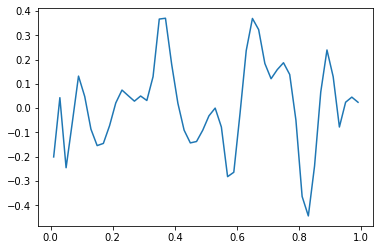

In [11]:
plot(jnp.linspace(0.01,0.99), model.apply(params, jnp.linspace(0.01,0.99), jnp.ones([1])))

In [12]:
def neural_nbody_ode(state, a, cosmo, params):
    """
    state is a tuple (position, velocities)
    """
    pos, vel = state
    
    kvec = fftk(mesh_shape)

    delta = cic_paint(jnp.zeros(mesh_shape), pos)
    
    delta_k = jnp.fft.rfftn(delta)
    
    # Computes gravitational potential
    pot_k = delta_k * laplace_kernel(kvec) * longrange_kernel(kvec, r_split=0)
    
    # Apply a correction filter
    kk = sum((ki/pi)**2 for ki in kvec)/4.
    pot_k = pot_k *(1. + model.apply(params, kk, jnp.atleast_1d(a)))
    
    # Computes gravitational forces
    forces = jnp.stack([cic_read(jnp.fft.irfftn(gradient_kernel(kvec, i)*pot_k), pos) 
                      for i in range(3)],axis=-1)
    
    forces = forces * 1.5 * cosmo.Omega_m

    # Computes the update of position (drift)
    dpos = 1. / (a**3 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * vel
    
    # Computes the update of velocity (kick)
    dvel = 1. / (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a))) * forces
    
    return dpos, dvel

In [13]:
# Run the simulation at the same steps
resi = odeint(neural_nbody_ode, [pos_i, vel_i], jnp.array([a_i]+scales), cosmo, paramsi, rtol=1e-5, atol=1e-5)

<ipython-input-12-b14f0c49fe59>:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum((ki/pi)**2 for ki in kvec)/4.


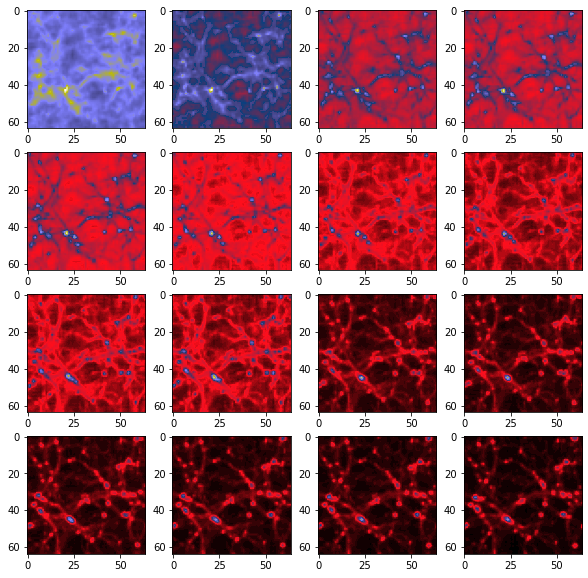

In [14]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][1:][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

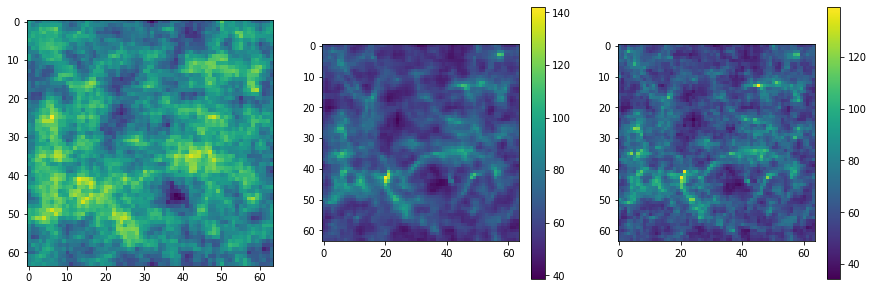

In [15]:
figure(figsize=[15,5])
subplot(131)
imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][0]).sum(axis=0))
subplot(132)
imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][1]).sum(axis=0)); colorbar()
subplot(133)
imshow(cic_paint(jnp.zeros(mesh_shape), poss[0]).sum(axis=0)); colorbar()

In [16]:
ref_pos = jnp.stack(poss, axis=0)
ref_vel = jnp.stack(vels, axis=0)

@jax.jit
def loss_fn(params):
  res = odeint(neural_nbody_ode, [pos_i, vel_i], jnp.array([a_i]+scales), cosmo, params, rtol=1e-5, atol=1e-5) 
  distance = jnp.sum((res[0][1:] - ref_pos)**2, axis=-1)
  vel = jnp.sum((res[1][1:] - ref_vel)**2, axis=-1)
  w = jnp.where(distance < 100, distance, 0.)
  wv = jnp.where(distance < 100, vel, 0.)
  return jnp.mean(w) #+ 0.001*jnp.mean(wv)

@jax.jit
def update(params, opt_state):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [17]:
losses = []

In [18]:
import optax
from tqdm import tqdm
learning_rate=0.01
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [45]:
for step in tqdm(range(100)):
  l, params, opt_state = update(params, opt_state)
  losses.append(l)

 23%|██▎       | 23/100 [03:31<11:48,  9.20s/it]


KeyboardInterrupt: 

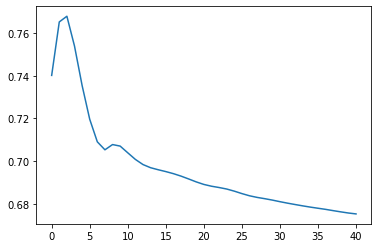

In [48]:
plot(losses[10:])

In [71]:
import pickle
pickle.dump( params, open( "node.params", "wb" ) )

In [49]:
res = odeint(neural_nbody_ode, [pos_i, vel_i], jnp.array([a_i]+scales), cosmo, params, rtol=1e-5, atol=1e-5) 

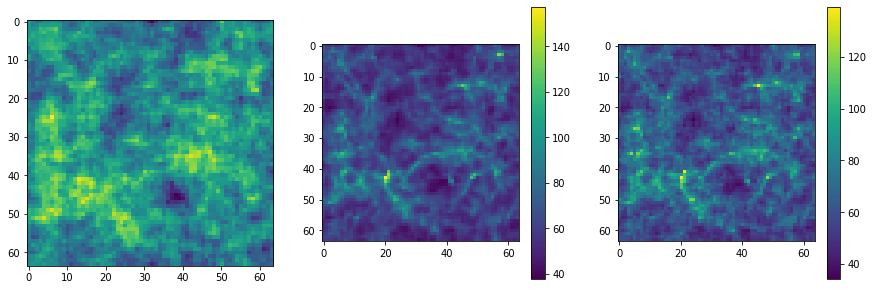

In [50]:
figure(figsize=[15,5])
subplot(131)
imshow(cic_paint(jnp.zeros(mesh_shape), res[0][0]).sum(axis=0))
subplot(132)
imshow(cic_paint(jnp.zeros(mesh_shape), res[0][1]).sum(axis=0));colorbar()
subplot(133)
imshow(cic_paint(jnp.zeros(mesh_shape), ref_pos[0]).sum(axis=0));colorbar()

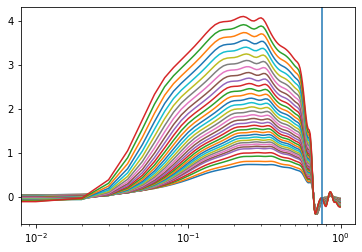

In [74]:
for i, a in enumerate(scales): 
    semilogx(jnp.linspace(0.00,0.99,100), model.apply(params, jnp.linspace(0.0,0.99,100), jnp.atleast_1d(a)))
axvline(3./4.)

In [52]:
import tensorflow as tf
import flowpm

In [53]:
k, pk_ref = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), poss[0]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pki = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), resi[0][1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pk = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), res[0][1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

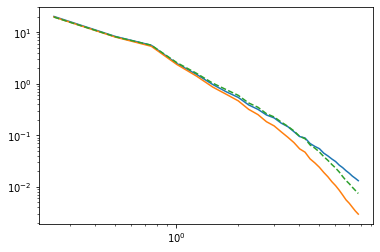

In [54]:
loglog(k,pk_ref[0])
loglog(k,pki[0])
loglog(k,pk[0],'--')

In [55]:
resi = odeint(neural_nbody_ode, [pos_i, vel_i], jnp.array([a_i]+scales), cosmo, paramsi, rtol=1e-5, atol=1e-5) 

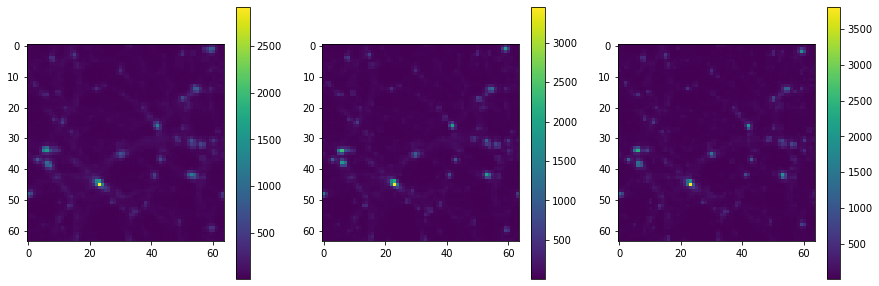

In [56]:
figure(figsize=[15,5])
subplot(131)
imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][-1]).sum(axis=0));colorbar()
subplot(132)
imshow(cic_paint(jnp.zeros(mesh_shape), res[0][-1]).sum(axis=0));colorbar()
subplot(133)
imshow(cic_paint(jnp.zeros(mesh_shape), poss[-1]).sum(axis=0));colorbar()

In [57]:
k, pk_ref = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), poss[-1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pki = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), resi[0][-1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pk = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), res[0][-1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

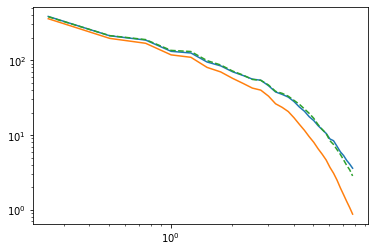

In [58]:
loglog(k,pk_ref[0])
loglog(k,pki[0])
loglog(k,pk[0],'--')

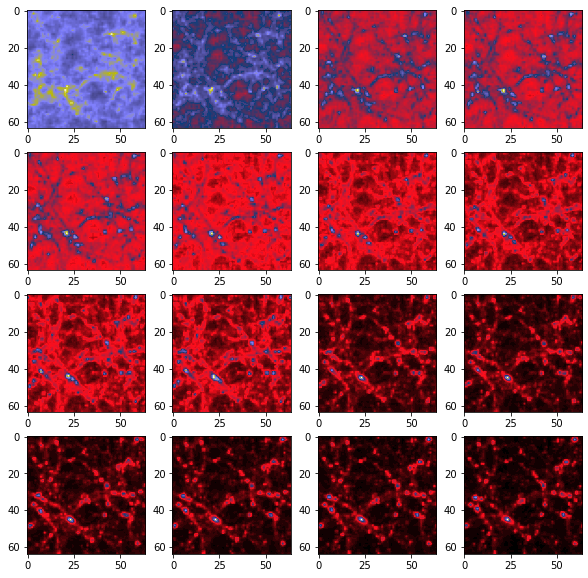

In [59]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0), cmap='gist_stern',vmin=0)

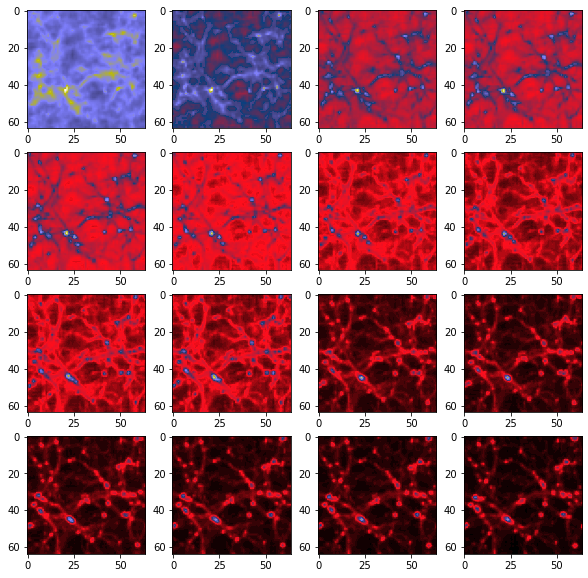

In [60]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi[0][1:][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

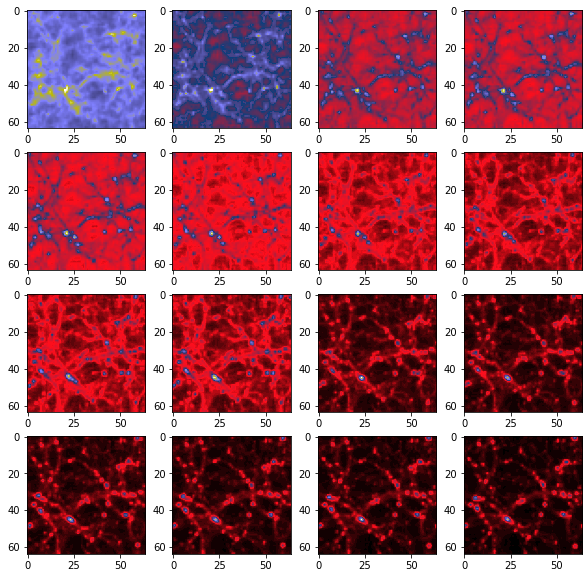

In [61]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res[0][1:][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss[::2][i]).sum(axis=0).max(),vmin=0)

In [62]:
# So let's see what happens on a different simulation
val_snap = '/data/CAMELS/Sims/IllustrisTNG_DM/1P_20/'
init_cond_val = val_snap+'ICs/ics'

header   = readgadget.header(init_cond_val)
Omega_m_val  = header.omega_m      #value of Omega_m
Omega_l_val  = header.omega_l      #value of Omega_l
h_val        = header.hubble       #value of h    
print('Validation parameter for omega_m', Omega_m_val)

# For 1P_20, sigma8 = 0.96000
cosmo_val = jc.Planck15(Omega_c= Omega_m_val - 0.049, Omega_b=0.049, n_s=0.9624, h=0.671 , sigma8=0.96)

redshift = header.redshift     #redshift of the snapshot

ptype = [1] #dark matter is particle type 1
ids_val_i = np.argsort(readgadget.read_block(init_cond_val, "ID  ", ptype)-1)  #IDs starting from 0
pos_val_i = readgadget.read_block(init_cond_val, "POS ", ptype)[ids_i]/1e3     #positions in Mpc/h
vel_val_i = readgadget.read_block(init_cond_val, "VEL ", ptype)[ids_i]         #peculiar velocities in km/s

# Reordering data for simple reshaping
pos_val_i = pos_val_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
vel_val_i = vel_val_i.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
pos_val_i = (pos_val_i/BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
vel_val_i = (vel_val_i / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])

Validation parameter for omega_m 0.3


In [63]:
poss_val = []
vels_val = []

# Loading all the intermediate snapshots
for i in tqdm(range(34)):
    snapshot= val_snap+ 'snap_%03d.hdf5'%i
    
    header   = readgadget.header(snapshot)
    
    redshift = header.redshift     #redshift of the snapshot
    
    ptype = [1] #dark matter is particle type 1
    ids = np.argsort(readgadget.read_block(snapshot, "ID  ", ptype)-1)   #IDs starting from 0
    pos = readgadget.read_block(snapshot, "POS ", ptype)[ids]/1e3 #positions in Mpc/h
    vel = readgadget.read_block(snapshot, "VEL ", ptype)[ids]     #peculiar velocities in km/s

    # Reordering data for simple reshaping
    pos = pos.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    vel = vel.reshape(4,4,4,64,64,64,3).transpose(0,3,1,4,2,5,6).reshape(-1,3)
    
    pos = (pos / BoxSize * 64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    vel = (vel / 100 * (1./(1+redshift)) / BoxSize*64).reshape([256,256,256,3])[::4,::4,::4,:].reshape([-1,3])
    
    poss_val.append(pos)
    vels_val.append(vel)

100%|██████████| 34/34 [02:29<00:00,  4.39s/it]


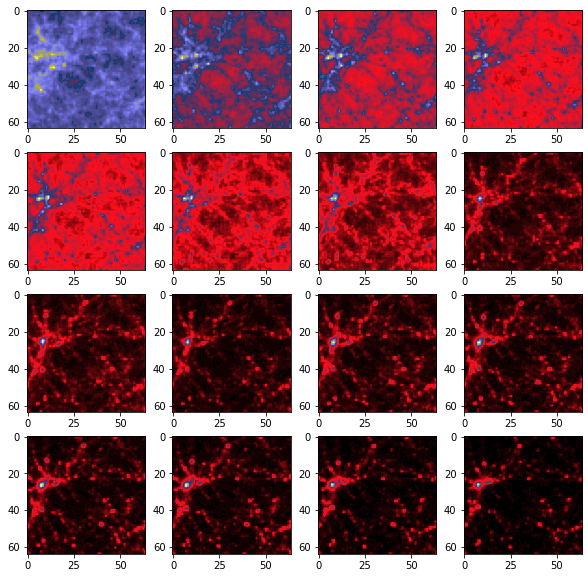

In [64]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), poss_val[::2][i]).sum(axis=0), cmap='gist_stern',vmin=0)

In [65]:
resi_val = odeint(neural_nbody_ode, [pos_val_i, vel_val_i], jnp.array([a_i]+scales), cosmo_val, paramsi, rtol=1e-5, atol=1e-5) 

<ipython-input-12-b14f0c49fe59>:17: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kk = sum((ki/pi)**2 for ki in kvec)/4.


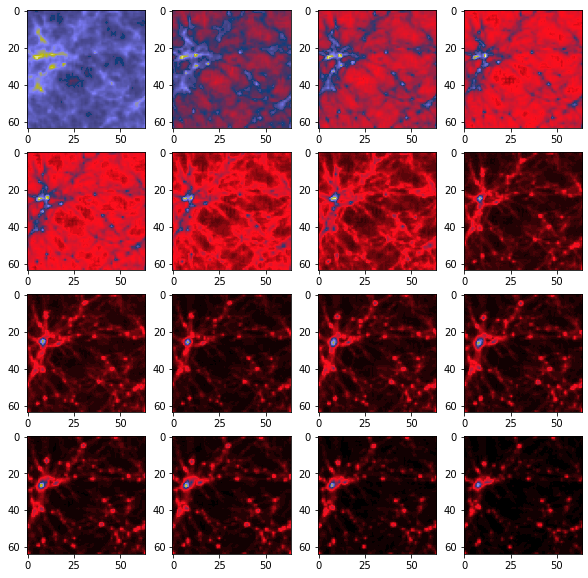

In [66]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), resi_val[0][1:][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss_val[::2][i]).sum(axis=0).max(),vmin=0)

In [67]:
res_val = odeint(neural_nbody_ode, [pos_val_i, vel_val_i], jnp.array([a_i]+scales), cosmo_val, params, rtol=1e-5, atol=1e-5) 

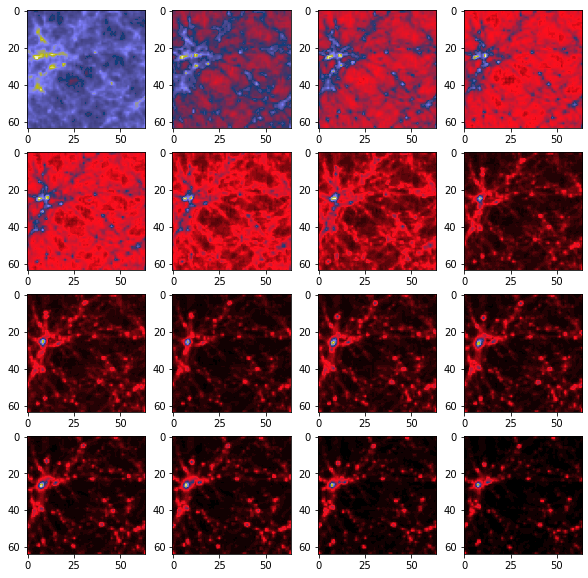

In [68]:
figure(figsize=[10,10])
for i in range(16):
    subplot(4,4,i+1)
    imshow(cic_paint(jnp.zeros(mesh_shape), res_val[0][1:][::2][i]).sum(axis=0), cmap='gist_stern',
           vmax=cic_paint(jnp.zeros(mesh_shape), poss_val[::2][i]).sum(axis=0).max(),vmin=0)

In [69]:
k, pk_ref = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), poss_val[-1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pki = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), resi_val[0][-1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

_, pk = flowpm.power_spectrum(
      tf.convert_to_tensor(cic_paint(jnp.zeros(mesh_shape), res_val[0][-1]).reshape([1,64,64,64])),
      boxsize=np.array([25.] * 3),
      kmin=np.pi / 25.,
      dk=2 * np.pi / 25.)

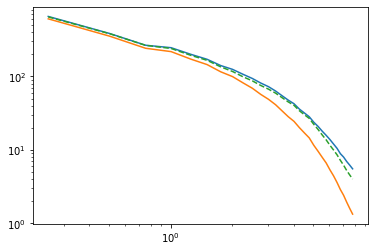

In [70]:
loglog(k,pk_ref[0])
loglog(k,pki[0])
loglog(k,pk[0],'--')